In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/My\ Drive/project_analysis

/content/drive/My Drive/project_analysis


In [ ]:
! du -sh logs

23G	logs


In [ ]:
from pycocotools.coco import COCO
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from pathlib import Path, PurePath
import torch
import pandas as pd

import argparse
import json
import torchvision.transforms as T

import torchvision

from tqdm import tqdm

import seaborn as sns

from util.box_ops import box_iou, box_cxcywh_to_xyxy


from PIL import Image, ImageDraw, ImageFont


from sklearn.linear_model import LinearRegression

from scipy.stats.stats import pearsonr


In [ ]:
# sns.set(rc={'figure.figsize':(8, 6)})
sns.set(rc={'figure.figsize':(18, 10)})
sns.set(font_scale=1.5)

In [ ]:
annot_train_path_coco = "/cs/usr/segal/proj/coco/annotations/instances_train2017.json"
imgs_train_path_coco = "/cs/usr/segal/proj/coco/train2017"
annot_train_path_pvoc = "/cs/++/usr/segal/pvoc/annotations/instances_train_pvoc.json"
imgs_train_path_pvoc = "/cs/++/usr/segal/pvoc/images"
annot_val_path = "/cs/usr/segal/proj/coco/annotations/instances_val2017.json"

In [ ]:
class Args:
    def __init__(self, action, dates, dataset_path, log_dir, cycles=8):
        self.action = action
        self.dates = dates
        self.log_dir = log_dir
        self.dataset_path = dataset_path
        self.cycles = cycles

# Post-Hoc Functions

In [ ]:
def get_test_stats_diff(q, q_prev):

    losses = ['test_loss', 'test_loss_bbox', 'test_class_error']

    loss_diff = {}

    for l in losses:
        loss_diff["diff_" + l] = q['eval_stats'][l] - q_prev['eval_stats'][l]

    return loss_diff

def get_test_losses(q):
    losses = ['test_loss', 'test_loss_bbox', 'test_class_error', 'test_coco_eval_bbox', 'mAP']
    
    loss_dict = {}
    for l in losses:
        loss_dict[l] = q['eval_stats'][l]

    return loss_dict



def get_area_box(box):
    x, y, w, h = box
    return w * h


def get_mean_n_boxes(outputs, n_cls):
    n = 0
    for i, output in enumerate(outputs):
        for logits, box in zip(output['pred_logits'][0], output['pred_boxes'][0]):
            cls = logits.argmax()
            if cls >= n_cls:
                continue
            # print("[overlaps] cls:", cls)
            n += 1
    return n / len(outputs)


def get_iou_means(outputs, n_cls):
    iou_img_means = []

    for i, output in enumerate(outputs):
        boxes = []
        for logits, box in zip(output['pred_logits'][0], output['pred_boxes'][0]):
            cls = logits.argmax()
            if cls >= n_cls:
                continue
            # print("[overlaps] cls:", cls)
            boxes.append(box)

        # iou over all pairs in the image
        ious = []
        for i in range(len(boxes)):
            for j in range(i + 1, len(boxes)):
                iou, union = box_iou(box_cxcywh_to_xyxy(boxes[i]).unsqueeze(0),
                                    box_cxcywh_to_xyxy(boxes[j]).unsqueeze(0))
                ious.append(iou[0].item())

        if len(ious) == 0:
            ious.append(0)

        iou_img_means.append(np.array(ious).mean())

    iou_means = np.array(iou_img_means).mean()
    print(iou_means)
    return iou_means


def get_features_means(outputs, n_cls, dict_funcs):
    # mean area of bounding boxes across all the fetched images
    # counting only areas where there were objects

    features = {}
    for k, v in dict_funcs.items():
        features[k] = np.array([])

    for i, output in enumerate(outputs):
        for logits, box in zip(output['pred_logits'][0], output['pred_boxes'][0]):
            cls = logits.argmax()
            if cls >= n_cls:
                continue
            #print("cls:", cls)
            for k, func in dict_funcs.items():
                features[k] = np.append(features[k], func(box))

    res = {}
    # aggregate
    for k, f in features.items():
        res[k] = f.mean()

    return res



def get_outputs(model, imgs_info, imgs_train_path):
    # standard PyTorch mean-std input image normalization
    transform = T.Compose([
        T.Resize(800),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    outputs = []
    model.eval()
    for i in range(len(imgs_info)):
        print(i)
        img_path = os.path.join(imgs_train_path, imgs_info[i]['file_name'])
        img = Image.open(img_path)
        img = transform(img).unsqueeze(0)
        out = model(img)
        outputs.append(out)

    print('finishing running model on images')
    return outputs


def get_resnet_features(imgs_info, imgs_train_path):
    model = torchvision.models.resnet18(pretrained=True)
    feature_extractor = torch.nn.Sequential(*list(model.children())[:-1])
    
    feature_extractor.eval()
    
    transform = T.Compose([
        T.Resize(224),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    tp = torch.float32
    dim = 512
    outputs = torch.zeros(len(imgs_info), dim)

    with torch.no_grad():
      for i in range(len(imgs_info)):
          if i % 50 == 0:
              print("{}/{}".format(i, len(imgs_info)))
          feature_extractor.eval()
          img_path = os.path.join(imgs_train_path, imgs_info[i]['file_name'])
          img = Image.open(img_path)
          img = transform(img).unsqueeze(0)
          out = feature_extractor(img).reshape(-1)
          outputs[i] = out
  
      print('finishing running model on images')
    return outputs
  
  
      
  

In [ ]:
def build_df(logs_dir, dataset_path, dates, dataset="pvoc", cycles=8):
    if dataset == "pvoc":
        n_cls = 21
    elif dataset == "kitti":
        n_cls = 9
    else:
        n_cls = 91

    n_method = {}

    df = pd.DataFrame({"log":[], "method":[], "cycle": [],
                       'prev_test_loss': [],
                       "diff_test_loss": [],
                       "diff_test_loss_bbox":[],
                       "diff_test_class_error": [],
                       "mean_area_bbox": [],
                       "mean_n_bbox": []
                       })

    #dir_path = Path(args.log_dir)
    dir_path = Path(logs_dir)
    log_dirs = []
    for date in dates:
        log_dirs = log_dirs + [pth for pth in dir_path.iterdir() if date in pth.name]

    annot_train_path = dataset_path + "/annotations/instances_train_{}.json".format(dataset)
    imgs_train_path = dataset_path + "/images"
    coco = COCO(annot_train_path)

    f_name = "run_data.json"
    for log in log_dirs:
        path = os.path.join(log, f_name)
        with open(path, 'r') as f:
            data = json.load(f)
        
        method = data['args']['al_method']
        if method == "cls_hardness":
            if 'inv_var' in data['args']:
                inv_var = data['args']['inv_var']
                method = "{}_{}".format(method, inv_var)
                has_inv_var = True
            else:
                has_inv_var = False
        if method in n_method:
            n_method[method] += 1
        else:
            n_method[method] = 1

        cycles = len(data['queries_data'])
        for c in range(1, cycles):

            q_cur = data['queries_data'][c]
            q_prev = data['queries_data'][c-1]
            losses_diff = get_test_stats_diff(q_cur, q_prev)

            cur_log = log / "q_model_info"
    
            out_name = "/{}_output_preds.zip".format(c + 1)
            path_preds = str(cur_log) + out_name
            
            if not os.path.isfile(path_preds):
                path_preds = path_preds.replace(".zip", "")


            outputs_live = torch.load(path_preds, map_location='cpu')  # list of ouptput tensors from the model

            outputs = outputs_live

            f = {"mean_area_bbox": get_area_box}
            features = get_features_means(outputs, n_cls, f)

            iou_means = get_iou_means(outputs, n_cls)

            mean_n_boxes = get_mean_n_boxes(outputs, n_cls)

            prev_test_loss = q_prev['eval_stats']['test_loss']

            entry = {"log": log, "cycle": c, **losses_diff,
                     "mean_area_bbox": features['mean_area_bbox'],
                     "mean_n_bbox": mean_n_boxes,
                     "mean_iou": iou_means, 
                     "prev_test_loss": prev_test_loss,
                     "method": method}
            df = df.append(entry, ignore_index=True)
 
    df['cycle'] = df['cycle'].astype(int)
    df.to_csv("df_mc_with_iou.csv")


    x = df['mean_n_bbox']
    y = df['diff_test_loss_bbox']
    c = df['cycle']

    return df

# Post Hoc Analysis

In [ ]:
dates = ["08", "09"]
log_dir = "./logs"
dataset_path = "./pvoc"

In [ ]:
# df_mc = build_df(log_dir, dataset_path, dates)
# df_mc["cycle"] = df_mc["cycle"].astype('int32')
df_mc = pd.read_csv("df_mc_with_less_features.csv")

In [ ]:
df_mc.head()

df_mc.shape

(144, 93)

In [ ]:

# def plot_feature(df, feature, metric):
#     x = df[feature]
#     y = df[metric]
#     c = df['cycle']
#     plt.xlabel(feature)
#     plt.ylabel(metric)
#     plt.scatter(x=x, y=y, c=c)
#     plt.title
#     plt.colorbar()
#     plt.show()


In [ ]:
import random
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler


def get_low_vif_features(features, df_mc):
  scaler = StandardScaler()
  
  df_reg = df_mc[features]
  df_reg = pd.DataFrame(scaler.fit_transform(df_reg), columns=df_reg.columns)
  
  vif_data = pd.DataFrame()
  
  scaler = StandardScaler()
  
  
  vif_data["feature"] = df_reg[features].columns
  vif_data["VIF"] = [variance_inflation_factor(df_reg[features].values, i)
                            for i in range(len(df_reg[features].columns))]
  
  vif_data = vif_data[vif_data["VIF"] < 10]
  return list(vif_data['feature'])
  

## Simple Hypotheses

In [ ]:

simple_features = ['mean_n_bbox', 'mean_area_bbox', 'mean_iou']

In [ ]:
import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler  

def regress(df_mc, predictors):
  controls = ['cycle','prev_test_loss']
  
  df_reg = df_mc[controls + predictors]
  response = df_mc['diff_test_loss']
  
  df_reg['cycle'] = np.log(df_reg['cycle'])
  
  scaler = StandardScaler()
  
  df_reg = pd.DataFrame(scaler.fit_transform(df_reg), columns=df_reg.columns)
  
  X  = sm.add_constant(df_reg)
  est = sm.OLS(response, X).fit()
  return est
  

In [ ]:
simple_features = ['mean_area_bbox', 'mean_iou','mean_n_bbox']
predictors = simple_features 
est1 = regress(df_mc, predictors)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
est1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         diff_test_loss   R-squared:                       0.777
Model:                            OLS   Adj. R-squared:                  0.769
Method:                 Least Squares   F-statistic:                     96.29
Date:                Sun, 12 Sep 2021   Prob (F-statistic):           3.07e-43
Time:                        10:31:35   Log-Likelihood:                -101.64
No. Observations:                 144   AIC:                             215.3
Df Residuals:                     138   BIC:                             233.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -1.2341      0.042    -29.579      0.000      -1.317      -1.152
cycle             -0.3553      0.119     -2.979      0.003      -0.591      -0.119
prev_test_loss    -1.3283      0.116    -11.467      0.000      -1.557      -1.099
mean_area_bbox    -0.1704      0.064     -2.647      0.009      -0.298      -0.043
mean_iou           0.1404      0.114      1.235      0.219      -0.084       0.365
mean_n_bbox       -0.1259      0.125     -1.004      0.317      -0.374       0.122
==============================================================================
Omnibus:                       10.209   Durbin-Watson:                   1.488
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               10.881
Skew:                           0.534   Prob(JB):                      0.00434
Kurtosis:                       3.820   Cond. No.                         7.83
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
p_vals_1 = est1.pvalues[3:]
p_vals_1

mean_area_bbox    0.009074
mean_iou          0.218831
mean_n_bbox       0.317312
dtype: float64

In [ ]:
table = est1.summary().tables[1]
s = table.as_latex_tabular()
s = s.replace('P$> |$t$|$', '$P$-value')
s = s.replace('mean\_n\_bbox', 'mean \# of bounding boxes')
s = s.replace('mean\_iou', 'mean IOU')
s = s.replace('mean\_area\_bbox', 'mean area of bounding boxes')
s = s.replace('prev\_test\_loss', 'previous test loss(control)')
s = s.replace('cycle', 'cycle(control)')
print(s)

\begin{center}
\begin{tabular}{lcccccc}
\toprule
                          & \textbf{coef} & \textbf{std err} & \textbf{t} & \textbf{$P$-value} & \textbf{[0.025} & \textbf{0.975]}  \\
\midrule
\textbf{const}            &      -1.2341  &        0.042     &   -29.579  &         0.000        &       -1.317    &       -1.152     \\
\textbf{cycle(control)}            &      -0.3553  &        0.119     &    -2.979  &         0.003        &       -0.591    &       -0.119     \\
\textbf{previous test loss(control)} &      -1.3283  &        0.116     &   -11.467  &         0.000        &       -1.557    &       -1.099     \\
\textbf{mean \# of bounding boxes}    &      -0.1259  &        0.125     &    -1.004  &         0.317        &       -0.374    &        0.122     \\
\textbf{mean area of bounding boxes} &      -0.1704  &        0.064     &    -2.647  &         0.009        &       -0.298    &       -0.043     \\
\textbf{mean IOU}        &       0.1404  &        0.114     &     1.235  &     

# Distance to the closest Centroid

In [ ]:
clustering_features = [col for col in df_mc.columns if "min_" in col]
clustering_features = get_low_vif_features(clustering_features, df_mc)

predictors = clustering_features
est2 = regress(df_mc, predictors)
est2.summary()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         diff_test_loss   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                     65.36
Date:                Sun, 12 Sep 2021   Prob (F-statistic):           1.06e-42
Time:                        10:27:25   Log-Likelihood:                -95.728
No. Observations:                 144   AIC:                             209.5
Df Residuals:                     135   BIC:                             236.2
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                           -1.2341      0.040    -30.482      0.000      -1.314      -1.154
cycle                           -0.3356      0.123     -2.724      0.007      -0.579      -0.092
prev_test_loss                  -1.2740      0.115    -11.100      0.000      -1.501      -1.047
min_dists_dim=2_n_cls=5          0.0529      0.060      0.877      0.382      -0.066       0.172
min_dists_dim=2_n_cls=25        -0.0184      0.052     -0.351      0.726      -0.122       0.085
min_dists_dim=2_n_cls=100       -0.0662      0.067     -0.995      0.322      -0.198       0.065
min_dists_dim=2_n_cls=500       -0.1783      0.064     -2.785      0.006      -0.305      -0.052
min_dists_dim=2_n_cls=1000       0.1876      0.055      3.403      0.001       0.079       0.297
min_dists_dim=512_n_cls=1000     0.0191      0.056      0.339      0.735      -0.092       0.130
==============================================================================
Omnibus:                        5.496   Durbin-Watson:                   1.553
Prob(Omnibus):                  0.064   Jarque-Bera (JB):                5.147
Skew:                           0.455   Prob(JB):                       0.0763
Kurtosis:                       3.172   Cond. No.                         8.54
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:

p_vals_2 = est2.pvalues[3:]
p_vals_2

min_dists_dim=2_n_cls=5         0.381926
min_dists_dim=2_n_cls=25        0.726490
min_dists_dim=2_n_cls=100       0.321643
min_dists_dim=2_n_cls=500       0.006121
min_dists_dim=2_n_cls=1000      0.000878
min_dists_dim=512_n_cls=1000    0.734982
dtype: float64

In [ ]:
from statsmodels.stats.multitest import fdrcorrection
p_vals = pd.concat((p_vals_1, p_vals_2))
res = fdrcorrection(p_vals, alpha=0.01)
res

(array([False, False, False, False, False, False, False,  True, False]),
 array([0.02722315, 0.48246405, 0.48246405, 0.49104833, 0.73498164,
        0.48246405, 0.02722315, 0.00790197, 0.73498164]))

In [ ]:
p_vals

mean_area_bbox                  0.009074
mean_iou                        0.218831
mean_n_bbox                     0.317312
min_dists_dim=2_n_cls=5         0.381926
min_dists_dim=2_n_cls=25        0.726490
min_dists_dim=2_n_cls=100       0.321643
min_dists_dim=2_n_cls=500       0.006121
min_dists_dim=2_n_cls=1000      0.000878
min_dists_dim=512_n_cls=1000    0.734982
dtype: float64

In [ ]:
table = est2.summary().tables[1]
s = table.as_latex_tabular()
s = s.replace('n\_cls', '\# clusters')
s = s.replace('dim=', 'dimension=')
s = s.replace('min\_dists\_', '')
print(s)

\begin{center}
\begin{tabular}{lcccccc}
\toprule
                                          & \textbf{coef} & \textbf{std err} & \textbf{t} & \textbf{P$> |$t$|$} & \textbf{[0.025} & \textbf{0.975]}  \\
\midrule
\textbf{const}                            &      -1.2341  &        0.040     &   -30.482  &         0.000        &       -1.314    &       -1.154     \\
\textbf{cycle}                            &      -0.3356  &        0.123     &    -2.724  &         0.007        &       -0.579    &       -0.092     \\
\textbf{prev\_test\_loss}                 &      -1.2740  &        0.115     &   -11.100  &         0.000        &       -1.501    &       -1.047     \\
\textbf{dimension=2\_\# clusters=5}      &       0.0529  &        0.060     &     0.877  &         0.382        &       -0.066    &        0.172     \\
\textbf{dimension=2\_\# clusters=25}     &      -0.0184  &        0.052     &    -0.351  &         0.726        &       -0.122    &        0.085     \\
\textbf{dimension=2\_\# clu

In [ ]:
#est2.summary()

pairs = []
sorted_cols = []
for i, f in enumerate(['constant'] + predictors):
  sorted_cols.append(f)
  pairs.append((f, est2.pvalues[i]))

k = sorted(pairs, key=lambda x: x[1])
  

sorted_cols = list(list(zip(*k))[0])
sorted_cols = [s for s in sorted_cols if "min" in s]
sorted_cols

In [ ]:
sns.regplot(data=df_mc, x='min_dists_dim=2_n_cls=1000', y='diff_test_loss')


In [ ]:
df_mc[features].corr()

In [ ]:
df_mc[clustering_features].corr()

,min_dists_dim=2_n_cls=5,min_dists_dim=2_n_cls=25,min_dists_dim=2_n_cls=100,min_dists_dim=2_n_cls=500,min_dists_dim=2_n_cls=1000,min_dists_dim=25_n_cls=5,min_dists_dim=25_n_cls=25,min_dists_dim=25_n_cls=100,min_dists_dim=25_n_cls=500,min_dists_dim=25_n_cls=1000,min_dists_dim=150_n_cls=5,min_dists_dim=150_n_cls=25,min_dists_dim=150_n_cls=100,min_dists_dim=150_n_cls=500,min_dists_dim=150_n_cls=1000,min_dists_dim=512_n_cls=5,min_dists_dim=512_n_cls=25,min_dists_dim=512_n_cls=100,min_dists_dim=512_n_cls=500,min_dists_dim=512_n_cls=1000
min_dists_dim=2_n_cls=5,1.000000,-0.065177,-0.569174,-0.593093,-0.483741,0.787141,-0.476879,-0.681821,-0.704498,-0.751426,0.792939,-0.440736,-0.654336,-0.710420,-0.767018,0.289339,-0.365507,-0.434781,-0.491856,-0.479002
min_dists_dim=2_n_cls=25,-0.065177,1.000000,0.472413,0.289501,0.259232,-0.383635,0.757213,0.435273,0.346350,0.306496,-0.378266,0.769140,0.487040,0.354366,0.272830,0.114987,0.473636,0.428080,0.441875,0.457299
min_dists_dim=2_n_cls=100,-0.569174,0.472413,1.000000,0.677903,0.590001,-0.684533,0.665005,0.753628,0.708418,0.708220,-0.689161,0.629341,0.789751,0.687382,0.669699,-0.253623,0.382328,0.442109,0.502679,0.525512
min_dists_dim=2_n_cls=500,-0.593093,0.289501,0.677903,1.000000,0.630787,-0.607585,0.577710,0.735591,0.707433,0.700441,-0.618190,0.566067,0.706475,0.737167,0.718201,-0.320434,0.282651,0.345201,0.405118,0.439099
min_dists_dim=2_n_cls=1000,-0.483741,0.259232,0.590001,0.630787,1.000000,-0.496004,0.527102,0.600817,0.636702,0.589695,-0.504793,0.488232,0.605270,0.621217,0.615203,-0.279198,0.233733,0.283407,0.332254,0.319261
min_dists_dim=25_n_cls=5,0.787141,-0.383635,-0.684533,-0.607585,-0.496004,1.000000,-0.640043,-0.766102,-0.754676,-0.767340,0.998556,-0.616616,-0.763333,-0.725834,-0.770413,0.147493,-0.589727,-0.619511,-0.679573,-0.672372
min_dists_dim=25_n_cls=25,-0.476879,0.757213,0.665005,0.577710,0.527102,-0.640043,1.000000,0.778254,0.747891,0.722731,-0.643631,0.986007,0.824206,0.737121,0.702781,-0.133679,0.516759,0.512567,0.553865,0.603406
min_dists_dim=25_n_cls=100,-0.681821,0.435273,0.753628,0.735591,0.600817,-0.766102,0.778254,1.000000,0.910097,0.890552,-0.774136,0.778977,0.959625,0.919484,0.886098,-0.303359,0.468878,0.532661,0.598744,0.646408
min_dists_dim=25_n_cls=500,-0.704498,0.346350,0.708418,0.707433,0.636702,-0.754676,0.747891,0.910097,1.000000,0.945194,-0.765579,0.734822,0.917722,0.950661,0.933215,-0.437271,0.349849,0.420343,0.512392,0.571287
min_dists_dim=25_n_cls=1000,-0.751426,0.306496,0.708220,0.700441,0.589695,-0.767340,0.722731,0.890552,0.945194,1.000000,-0.779101,0.704489,0.878401,0.944504,0.957164,-0.484175,0.293898,0.362786,0.473792,0.542717


# Multiple Linear Regression for controlling possible confounders

In [ ]:
df_mc_ctrl.head()

,log,method,cycle,prev_test_loss,diff_test_loss,diff_test_loss_bbox,diff_test_class_error,mean_area_bbox,mean_n_bbox,mean_iou
2,logs/cls_hardness_25.08_12:48_log,cls_hardness,3,13.598404,-1.356930,-0.144901,-2.077092,0.194756,2.994,[]
8,logs/cls_hardness_val_is_test_25.08_12:19_log,cls_hardness,3,13.523924,-1.304580,-0.127756,-0.505307,0.200723,2.930,[]
14,logs/cls_hardness_24.08_12:42_log,cls_hardness,3,13.346336,-1.386034,-0.099050,0.609257,0.174276,3.466,[]
20,logs/cls_hardness_val_is_test_22.08_11:47_log,cls_hardness,3,13.151120,-1.395560,-0.173206,-4.593954,0.175235,3.483,[]
26,logs/cls_hardness_27.08_23:20_log,cls_hardness,3,13.209572,-1.221383,-0.128645,-1.296919,0.167907,3.934,[]


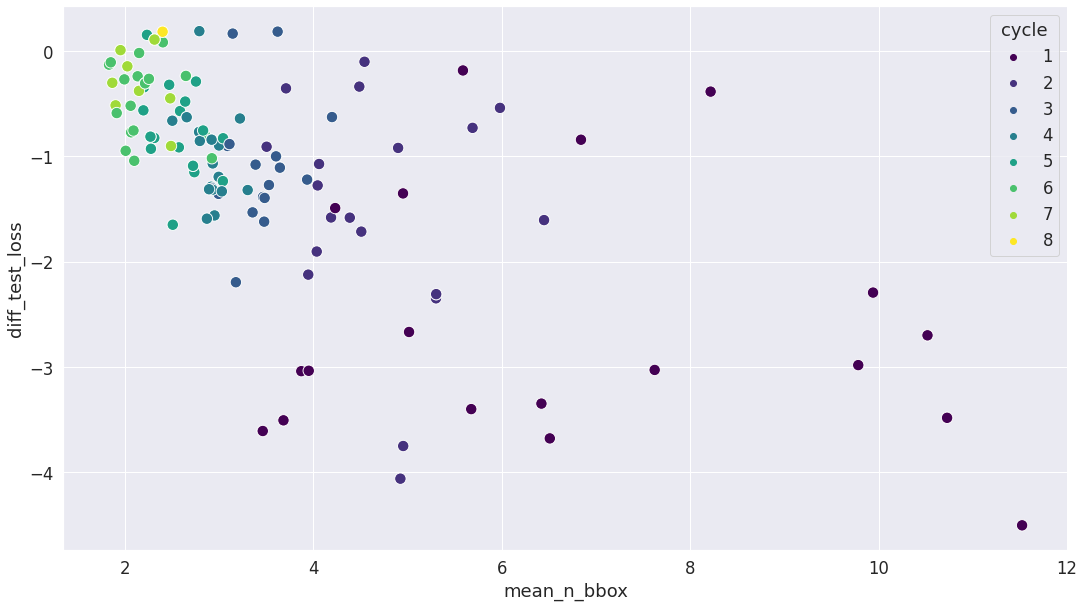

In [ ]:
# metric = 'diff_test_loss'
# f,ax=plt.subplots(1,len(features),figsize=(18,8))
# for i, f in enumerate(simple_features):
#     #sns.scatterplot(data=df_mc_ctrl, x=df_mc_ctrl[f], y=df_mc_ctrl[metric],  s=130, hue='cycle', ax=ax[i])
#     sns.scatterplot(data=df_mc, x=f, y='diff_test_loss',  s=130, hue='cycle')#, ax=ax[i])

#pl = sns.color_palette("icefire", n_colors=1000, as_cmap=True)
pl = sns.color_palette("viridis", n_colors=7, as_cmap=True)
sns.scatterplot(data=df_mc, x=f, y='diff_test_loss',  palette=pl, s=130, hue='cycle', legend='full')#, ax=ax[i])


TypeError: ignored

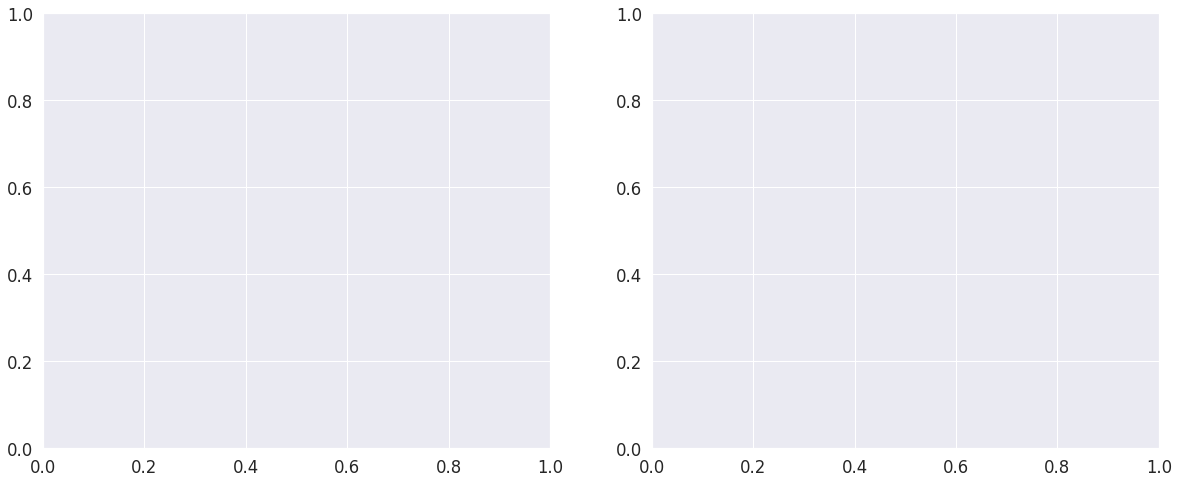

In [ ]:

#x = 'mean_n_bbox'
features = ['mean_n_bbox', 'mean_area_bbox']#, 'mean_iou']
features = ['mean_n_bbox', 'mean_area_bbox']#, 'min_dists_dim=2_n_cls=25']#, 'mean_iou']
metric = 'diff_test_loss'

f,ax=plt.subplots(1,len(features),figsize=(20,8))

# df_mc_ctrl = df_mc[df_mc['cycle'] == 5]
df = df_mc_ctrl
#df = df_mc
for i, f in enumerate(features):
    #sns.scatterplot(x=df[f], y=df[metric],  s=130, ax=ax[i])
    sns.lmplot(data=df, x=df[f], y=df[metric],  ax=ax[i], truncate=False)




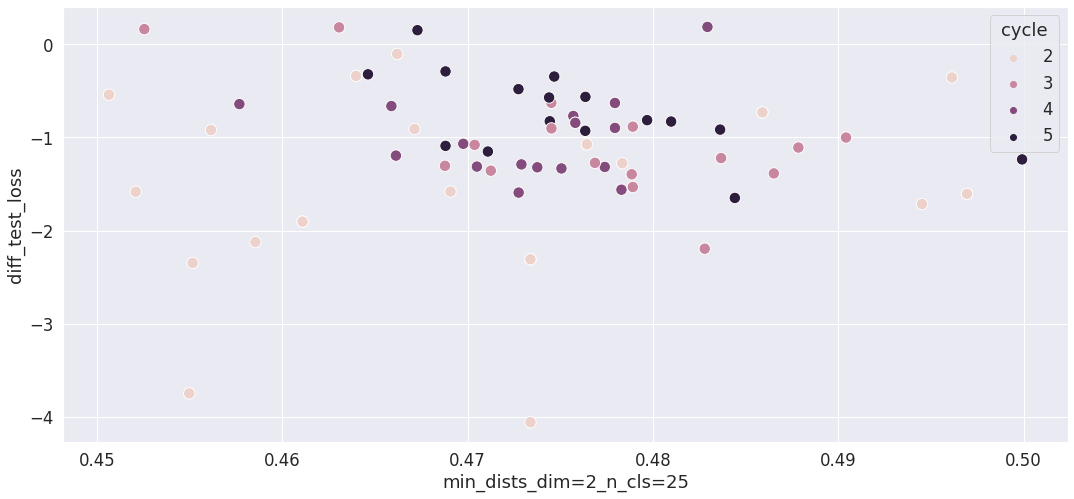

In [ ]:
# f = features[-1]

df_mc_ctrl = df_mc[(df_mc['cycle'] >= 2) & (df_mc['cycle'] <= 5) ]
sns.scatterplot(data=df_mc_ctrl, x=f, y=metric, hue='cycle', s=130)

In [ ]:
df_mc.head()

,Unnamed: 0,log,method,cycle,prev_test_loss,diff_test_loss,diff_test_loss_bbox,diff_test_class_error,mean_area_bbox,mean_n_bbox,mean_iou,min_dists_dim=2_n_cls=5,min_dists_dim=2_n_cls=10,min_dists_dim=2_n_cls=25,min_dists_dim=5_n_cls=5,min_dists_dim=5_n_cls=10,min_dists_dim=5_n_cls=25
0,0,logs/cls_hardness_25.08_12:48_log,cls_hardness,1,18.275839,-3.400819,-0.287529,-52.498684,0.125236,5.676,[],1.526262,0.877660,0.453911,1.439430,0.865960,0.510968
1,1,logs/cls_hardness_25.08_12:48_log,cls_hardness,2,14.875020,-1.276617,-0.261962,-11.249237,0.146471,4.046,[],1.663841,0.917152,0.478344,1.475879,0.903286,0.529494
2,2,logs/cls_hardness_25.08_12:48_log,cls_hardness,3,13.598404,-1.356930,-0.144901,-2.077092,0.194756,2.994,[],1.576235,0.864003,0.471251,1.382777,0.859402,0.526264
3,3,logs/cls_hardness_25.08_12:48_log,cls_hardness,4,12.241473,-1.289206,-0.076122,-1.386447,0.205381,2.915,[],1.555765,0.893402,0.472902,1.416002,0.874329,0.534157
4,4,logs/cls_hardness_25.08_12:48_log,cls_hardness,5,10.952267,-0.825561,-0.044768,-0.196530,0.227415,2.312,[],1.482279,0.899802,0.474434,1.368361,0.881921,0.531869


In [ ]:
df_mc.head()

,Unnamed: 0,log,method,cycle,prev_test_loss,diff_test_loss,diff_test_loss_bbox,diff_test_class_error,mean_area_bbox,mean_n_bbox,mean_iou,min_dists_dim=2_n_cls=5,min_dists_dim=2_n_cls=10,min_dists_dim=2_n_cls=25,min_dists_dim=5_n_cls=5,min_dists_dim=5_n_cls=10,min_dists_dim=5_n_cls=25
0,0,logs/cls_hardness_25.08_12:48_log,cls_hardness,1,18.275839,-3.400819,-0.287529,-52.498684,0.125236,5.676,[],1.526262,0.877660,0.453911,1.439430,0.865960,0.510968
1,1,logs/cls_hardness_25.08_12:48_log,cls_hardness,2,14.875020,-1.276617,-0.261962,-11.249237,0.146471,4.046,[],1.663841,0.917152,0.478344,1.475879,0.903286,0.529494
2,2,logs/cls_hardness_25.08_12:48_log,cls_hardness,3,13.598404,-1.356930,-0.144901,-2.077092,0.194756,2.994,[],1.576235,0.864003,0.471251,1.382777,0.859402,0.526264
3,3,logs/cls_hardness_25.08_12:48_log,cls_hardness,4,12.241473,-1.289206,-0.076122,-1.386447,0.205381,2.915,[],1.555765,0.893402,0.472902,1.416002,0.874329,0.534157
4,4,logs/cls_hardness_25.08_12:48_log,cls_hardness,5,10.952267,-0.825561,-0.044768,-0.196530,0.227415,2.312,[],1.482279,0.899802,0.474434,1.368361,0.881921,0.531869


In [ ]:
clustering_features = [col for col in df_mc.columns if "min_" in col]
# features = features + features2

In [ ]:
df_mc_ctrl = df_mc
df_corr = pd.DataFrame({'feature': [], 'correlation': [], 'p_value': []})
res = []

res = {}
for i, f in enumerate(features):

  corr, p_val = pearsonr(df_mc_ctrl['diff_test_loss'], df_mc_ctrl[f])
  print('correlation: {} and {}: {}'.format('test_loss', f, corr))
  entry = {'feature': f, 'correlation': corr, 'p_value': p_val}
  df_corr = df_corr.append(entry, ignore_index=True)


In [ ]:
df_corr.sort_values(by='p_value', axis=0)

NameError: ignored

In [ ]:
df_corr

,feature,correlation,p_value
0,mean_n_bbox,0.292907,0.087709
1,mean_area_bbox,-0.264975,0.123969


In [ ]:
dir_path = Path(args.log_dir)
log_dirs = []
for date in dates:
    log_dirs = log_dirs + [pth for pth in dir_path.iterdir() if date in pth.name]

NameError: ignored

In [ ]:


f = open("STA/train.txt", 'r')
temp_ids = f.read().replace("_", "").replace("'", "").split("\n")[:-1]
img_ids = [int(c_id) for c_id in temp_ids]

# n = 1000
# img_ids = img_ids[:n]

In [ ]:
dataset_path = "./pvoc"
annot_train_path = dataset_path + "/annotations/instances_train_pvoc.json"
imgs_train_path = dataset_path + "/images"
coco = COCO(annot_train_path)

# imgs_info = coco.loadImgs(ids=img_ids)
# features = get_resnet_features(imgs_info, imgs_train_path)
# features = torch.cat(features).detach()
# features = features.squeeze(-1).squeeze(-1)

In [ ]:
# torch.save(features, './features.pt')

In [ ]:
features = torch.load('./features.pt')

In [ ]:

features_np = features.numpy()

In [ ]:
! pip3 install umap-learn


     |████████████████████████████████| 80 kB 3.2 MB/s 
     |████████████████████████████████| 1.1 MB 28.6 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.1-py3-none-any.whl size=76564 sha256=8d5b02a342da8973bef297b4700e8d48e9ceb66256e8d69d07ae9fccb4db5906
  Stored in directory: /root/.cache/pip/wheels/01/e7/bb/347dc0e510803d7116a13d592b10cc68262da56a8eec4dd72f
  Created wheel for pynndescent: filename=pynndescent-0.5.4-py3-none-any.whl size=52373 sha256=dc3302b78eb71236eee6fe1841284541d83f1cb3a25129dd91f50994be170602
  Stored in directory: /root/.cache/pip/wheels/d0/5b/62/3401692ddad12324249c774c4b15ccb046946021e2b581c043
Successfully built umap-learn pynndescent


In [ ]:
import umap
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler  
from scipy.spatial.distance import cdist



In [ ]:
# normalize the features
scaler = StandardScaler()
features_norm = scaler.fit_transform(features_np)

In [ ]:
print(len(n_dims) * len(n_clusters))

81


In [ ]:
X = features_norm
n_dims = [2, 5, 10, 25, 50, 100, 150, 250, 512]
n_clusters = [5, 10, 25, 50, 100, 150, 200, 500, 1000]

dists_dict = {}
for d in n_dims:
    dists_dict[d] = {}

for d in n_dims:
  for n_cls in n_clusters:
    if d != 512:
      print('dim: {}, n_clusters: {}'.format(d, n_cls))
      u = umap.UMAP(n_components=d)
      embd = u.fit_transform(X)
      print("finished transform umap")
    else:
      embd = X.copy()
    kmeans = KMeans(n_clusters=n_cls, init='k-means++')
    kmeans.fit(embd)
    print("finished kmeans++")
    centers = kmeans.cluster_centers_
    # compute distance of all images from the cluster centers
    dists = cdist(embd, centers)
    dists_dict[d][n_cls] = dists





import pickle
obj = dists_dict
name = 'dists_dict'
with open('obj_'+ name + '.pkl', 'wb') as f:
    pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

print('done') 




In [ ]:
X = features_norm
u = umap.UMAP(n_components=2)
embd = u.fit_transform(X)
kmeans = KMeans(n_clusters=1000, init='k-means++')
kmeans.fit(embd)



KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=1000, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

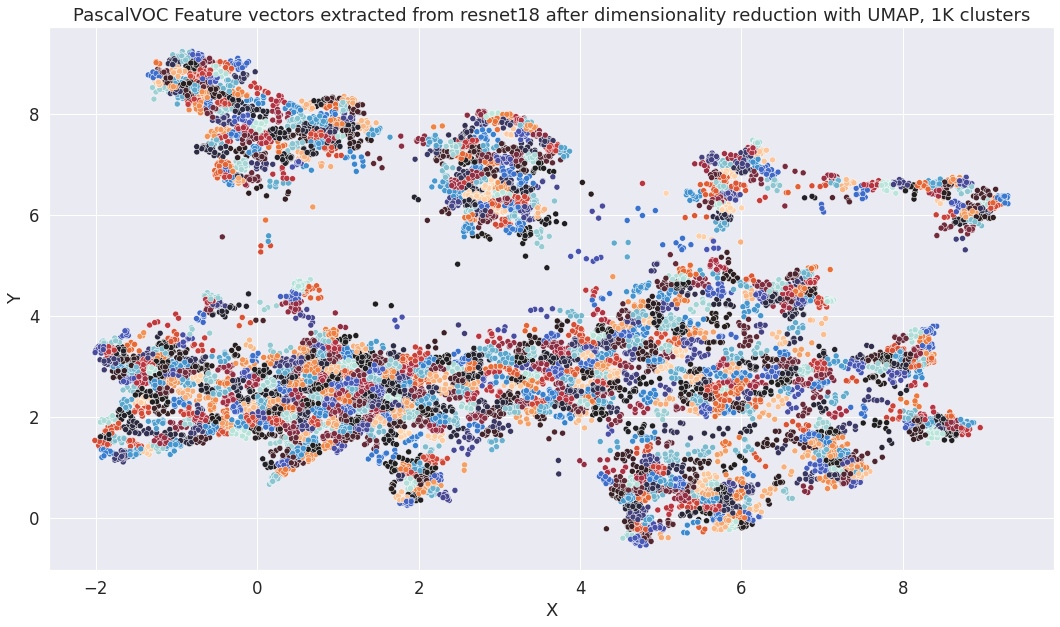

In [ ]:
df_embd = pd.DataFrame({'X': embd[:, 0], 'Y': embd[:, 1], 'label': kmeans.labels_})
df_embd['label'] = df_embd['label'].astype(np.float32)
# labels = kmeans.labels_
# sns.scatterplot(x=embd[:, 0], y=embd[:, 1], color=labels)
pl = sns.color_palette("icefire", n_colors=1000, as_cmap=True)

a=sns.scatterplot(data=df_embd, x='X', y='Y', hue='label', palette=pl, legend=False).set_title('PascalVOC Feature vectors extracted from resnet18 after dimensionality reduction with UMAP, 1K clusters')

In [ ]:
len(set(labels))

1000

In [ ]:
log_dirs = df_mc['log'].unique()


In [ ]:
df_mc['cycle'] = df_mc['cycle'].astype(int)

In [ ]:
dists_dict = pd.read_pickle('obj_dists_dict.pkl')

In [ ]:
df_simple = pd.read_csv('df_mc_with_iou.csv')
df_mc = df_simple

In [ ]:
log_dirs = df_mc['log'].unique()
# n_dims = [2, 5, 10, 25, 50, 100, 150, 250, 512]
n_dims = [2, 25, 150, 512]
n_clusters = [5, 25, 100, 500, 1000]
# n_clusters = [5, 10, 25, 50, 100, 150, 200, 500, 1000]
f_name = "run_data.json"

for d in n_dims:
  for n_cls in n_clusters:
    col_name = "min_dists_dim={}_n_cls={}".format(d, n_cls)
    df_mc[col_name] = np.zeros(df_mc.shape[0])
    for log in log_dirs:
        # iterations over cycles - row in the dataframe
        path = os.path.join(log, f_name) 
        with open(path, 'r') as f:
            data = json.load(f)
            cycles = len(data['queries_data'])
            for c in range(1, cycles):
              q_cur = data['queries_data'][c]
              cycle_ids = q_cur['img_ids']
              idx = np.in1d(img_ids, cycle_ids).nonzero()[0]
              dists = dists_dict[d][n_cls][idx]
              min_dists_mean = dists.min(axis=1).mean()
              df_mc.loc[(df_mc['log']== log) & (df_mc['cycle']== c), col_name] = min_dists_mean



  
          

In [ ]:
# df_mc.head()
# df_mc.to_csv('df_mc_with_less_features.csv')

In [ ]:
df_mc.head()

NameError: ignored

In [ ]:
%cd /home/daniel/project/ALCH


/home/daniel/project/ALCH


In [ ]:
df_mc.shape

(144, 32)

In [ ]:
len(df_mc['log'].unique())

22